In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from plotting_constants import nice_names, color_dict, stack_to_ax, plot_stacked_horizontal_bar

idx = pd.IndexSlice

In [2]:
from data_getter import (
    get_consumer_cost,
    get_model_balancing_volume
    )

consumer_cost_file = Path.cwd().parent / 'summaries' / 'total_summary_flex.csv'

model_balancing_volume = get_model_balancing_volume(consumer_cost_file)
consumer_cost = get_consumer_cost(consumer_cost_file)

c:\Users\lukas\OneDrive\Desktop\projects\nodal\UKLMP\notebooks\data_getter.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bv = pd.read_csv(
c:\Users\lukas\OneDrive\Desktop\projects\nodal\UKLMP\notebooks\data_getter.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cc = pd.read_csv(


In [3]:
balancing_share = 1 - model_balancing_volume['zonal'].mean() / model_balancing_volume['national'].mean()

In [4]:
balancing_share

0.8212110601551518

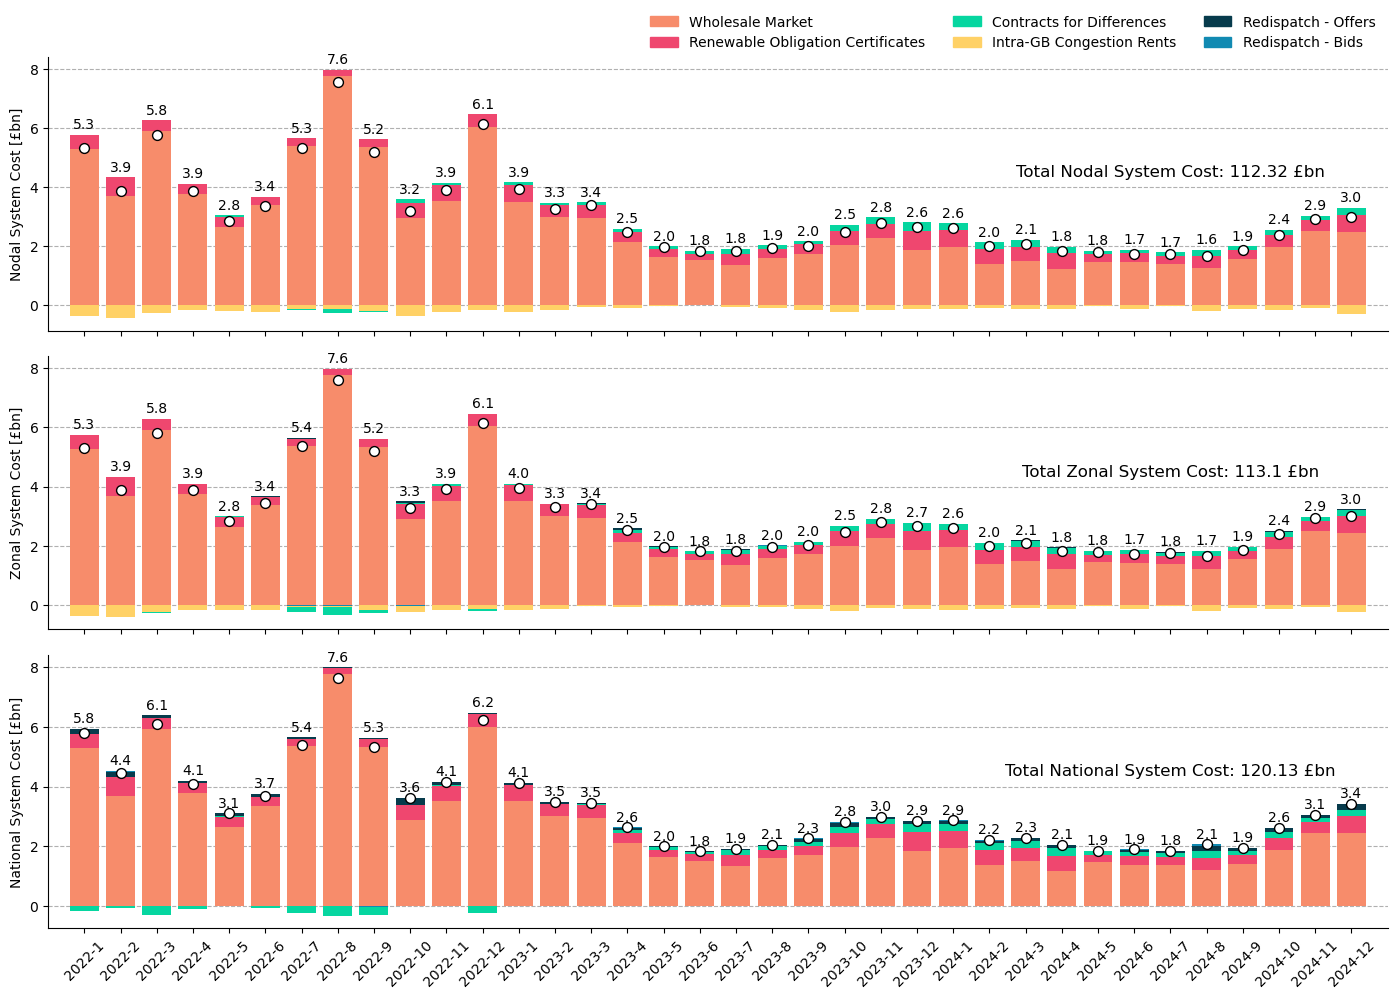

In [5]:
from warnings import filterwarnings
filterwarnings('ignore')

import logging
logging.getLogger('matplotlib.category').setLevel(logging.WARNING)

fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

for col, ax in zip(consumer_cost.columns, axs):

    ts = consumer_cost.index.get_level_values(0).unique()

    df_unstack = consumer_cost.loc[idx[:, :], col].unstack()
    df = df_unstack.groupby([df_unstack.index.year, df_unstack.index.month]).sum().mul(1e-3)

    for m in df.index:
        # stack_to_ax(total_costs, df.loc[[m]], ax)
        stack_to_ax(df.loc[[m]], ax)

    ax.set_ylabel(f'{col.capitalize()} System Cost [£bn]')
    ax.grid(axis='y', linestyle='--')
    ax.set_axisbelow(True)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlim(-1, len(df))

    total_cost = df.sum().sum()
    ax.text(
        len(df) - 6, 4.5,
        f'Total {col.capitalize()} System Cost: {np.around(total_cost, decimals=2)} £bn',
        ha='center',
        va='center',
        fontsize=12,
        # transform=ax.transAxes
    )

axs[2].tick_params(axis='x', labelrotation=45)
handles, labels = [], []

for name, nice_name in nice_names.items():

    if name == 'wholesale buying':
        continue
    handles.append(plt.Rectangle((0, 0), 1, 1, color=color_dict[name]))
    labels.append(nice_name)

axs[0].legend(
    handles,
    labels,
    # title='Cost Factors',
    # bbox_to_anchor=(1.01, 1.2),
    bbox_to_anchor=(0.44, 1.2),
    frameon=False,
    ncol=3
    )


plt.tight_layout()

plt.savefig('figures/total_monthly_costs.pdf')
plt.show()

In [6]:
nquants = len(consumer_cost.index.get_level_values(1).unique())

total_date_range = pd.date_range(
    consumer_cost.index.get_level_values(0).min().strftime('%Y-%m'),
    consumer_cost.index.get_level_values(0).max().strftime('%Y-%m'),
    freq='ME').strftime('%Y-%m')

total_hh = pd.date_range(
    consumer_cost.index.get_level_values(0).min().strftime('%Y-%m-%d'),
    consumer_cost.index.get_level_values(0).max().strftime('%Y-%m-%d'),
    freq='30min')

missing_share = pd.Series(np.nan, total_date_range)

for m in total_date_range:

    n_modelled = len(consumer_cost.loc[idx[m, :], :]) / nquants
    n_total = pd.date_range(m, pd.Timestamp(m) + pd.offsets.MonthEnd(1), freq='30min')

    missing_share[m] = 1 - n_modelled / len(n_total)

##### Combined: Total Costs National, Total Costs Zonal, Difference

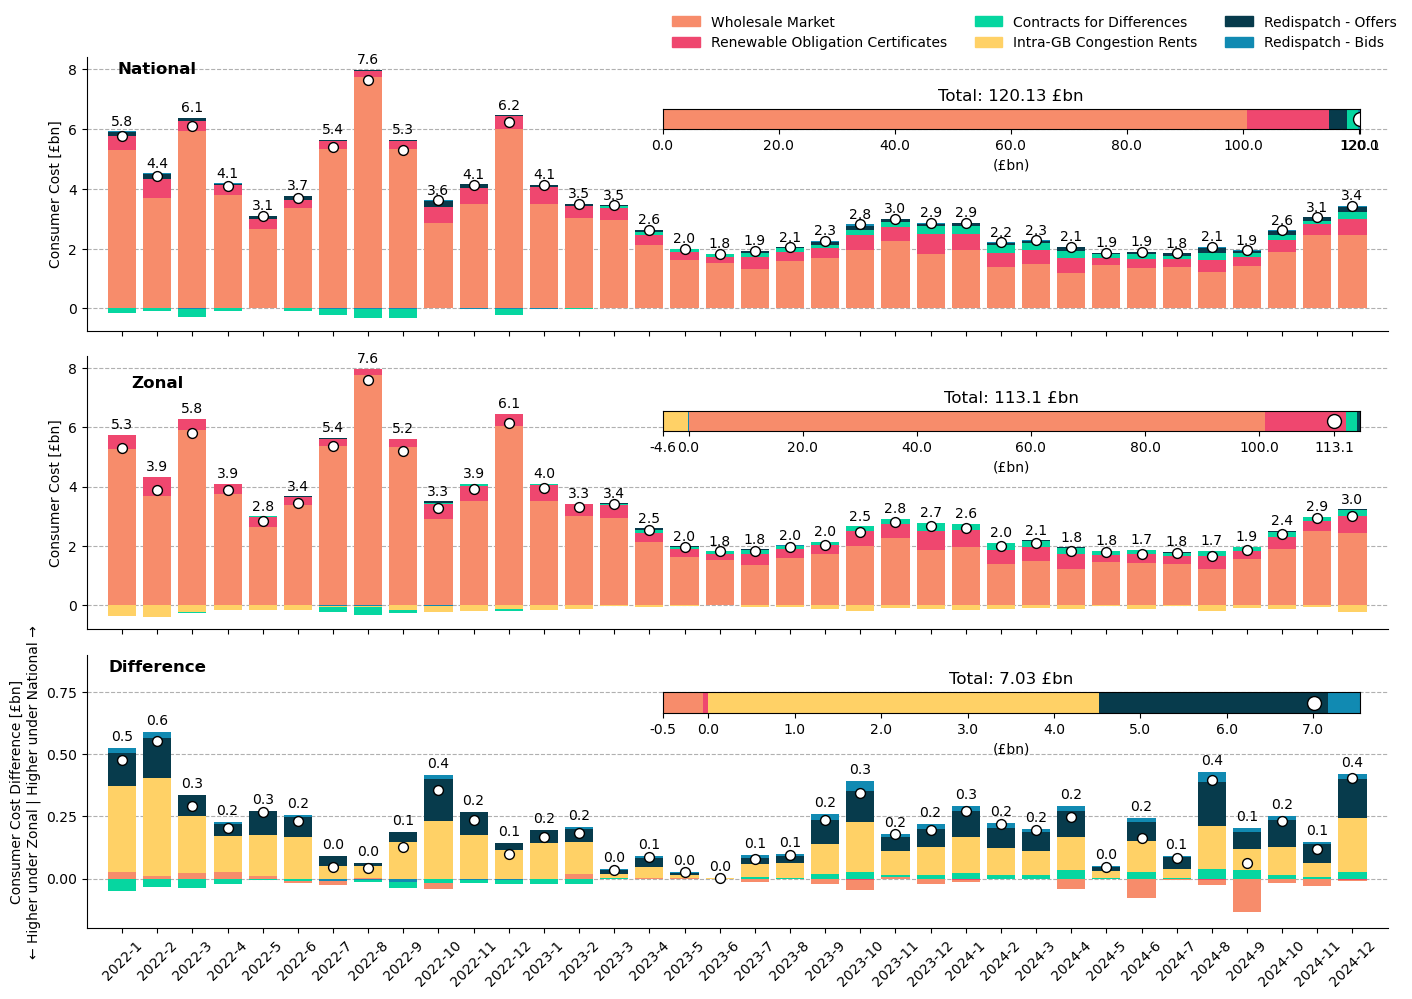

In [7]:
import warnings
warnings.filterwarnings('ignore')

fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

totals = {}

for col, ax in zip(['national', 'zonal'], axs[:2]):

    ts = consumer_cost.index.get_level_values(0).unique()

    df_unstack = consumer_cost.loc[idx[:, :], col].unstack()
    df = df_unstack.groupby([df_unstack.index.year, df_unstack.index.month]).sum().mul(1e-3)

    for m in df.index:
        # stack_to_ax(total_costs, df.loc[[m]], ax)
        stack_to_ax(df.loc[[m]], ax)

    ax.set_ylabel(f'Consumer Cost [£bn]')
    ax.grid(axis='y', linestyle='--')
    ax.set_axisbelow(True)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlim(-1, len(df))

    total_cost = df.sum().sum()
    totals[col] = total_cost

    '''
    ax.text(
        len(df) - 6, 5,
        f'Total: {np.around(total_cost, decimals=2)} £bn',
        ha='center',
        va='center',
        fontsize=12,
        # transform=ax.transAxes
    )
    '''
    ax.text(
        1, {'national': 8, 'zonal': 7.5}[col],
        f'{col.capitalize()}',
        ha='center',
        va='center',
        fontsize=12,
        fontweight='bold',
        # transform=ax.transAxes
    )
    ax.set_yticks([0, 2, 4, 6, 8])


    y_shift = 0.01 if col == 'zonal' else 0.04

    # Create a new axis based on relative coordinates to ax
    new_ax = ax.figure.add_axes([
        ax.get_position().x0 + 0.32, 
        ax.get_position().y0 + ax.get_position().height * 0.8 + y_shift, 
        ax.get_position().width * 0.6, 
        ax.get_position().height * 0.09
        ])

    plot_stacked_horizontal_bar(df.sum(), new_ax)
    new_ax.set_title(f'Total: {np.around(total_cost, decimals=2)} £bn')
    
for layout, ax in zip(['zonal'], axs[2:]):

    ss = (consumer_cost['national'] - consumer_cost[layout]).unstack()

    ss = (
        ss
        .groupby([ss.index.year, ss.index.month]).sum().mul(1e-3)
    )
    for m in ss.index:
        stack_to_ax(ss.loc[[m]], ax, text_y_offset=0.03)

    ax.set_ylabel(f'Consumer Cost Difference [£bn]\n← Higher under Zonal | Higher under National →')
    ax.grid(axis='y', linestyle='--')
    ax.set_axisbelow(True)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlim(-1, len(ss))

    total_cost = ss.sum().sum()

    if layout == 'zonal':
        y = 0.625
    else:
        y = 0.65

    total_diff = totals['national'] - totals[layout]

    '''
    ax.text(
        len(ss) - 6, y,
        f'Total: {np.around(total_diff, decimals=2)} £bn',
        ha='center',
        va='center',
        fontsize=12,
        # transform=ax.transAxes
    )
    '''

    new_ax = ax.figure.add_axes([
        ax.get_position().x0 + 0.32,
        ax.get_position().y0 + ax.get_position().height * 0.8 + 0.0, 
        ax.get_position().width * 0.6, 
        ax.get_position().height * 0.09
        ])

    plot_stacked_horizontal_bar(ss.sum(), new_ax, right_tick=False)
    new_ax.set_title(f'Total: {np.around(total_diff, decimals=2)} £bn')

    ax.text(
        1, 0.85,
        'Difference',
        ha='center',
        va='center',
        fontweight='bold',
        fontsize=12,
        # transform=ax.transAxes
    )
    ax.set_yticks([0, 0.25, 0.5, 0.75])
    ax.set_ylim(-0.2, 0.9)

axs[2].tick_params(axis='x', labelrotation=45)

handles, labels = [], []

for name, nice_name in nice_names.items():

    if name == 'wholesale buying':
        continue
    handles.append(plt.Rectangle((0, 0), 1, 1, color=color_dict[name]))
    labels.append(nice_name)

axs[0].legend(
    handles,
    labels,
    bbox_to_anchor=(0.44, 1.2),
    frameon=False,
    ncol=3
    )

plt.tight_layout()

for ax, text, y in zip(axs, ['a', 'b', 'c'], [8.5, 8.5, 0.85]):
    '''
    ax.text(
        -1.5, y, text, weight='bold', fontsize=13.5,
    )
    '''

# plt.savefig('figures/total_monthly_costs_w_comparison.pdf')
plt.show()

In [8]:
# rev_nat = pd.read_csv(Path.cwd().parent / 'summaries' / 'total_unit_revenues_flex_national.csv', index_col=[0,1], parse_dates=True)
# rev_zon = pd.read_csv(Path.cwd().parent / 'summaries' / 'total_unit_revenues_flex_zonal.csv', index_col=[0,1], parse_dates=True)

In [9]:
revrev = pd.read_csv(Path.cwd().parent / 'summaries' / 'total_unit_revenues_flex.csv', index_col=[0,1,2], parse_dates=True)

In [10]:
revrev.head()

2022-01-01  2022-01-02  2022-01-03  2022-01-04  \
ABERU-1 national bid_cost       0.000000         0.0         0.0         0.0   
                 cfd            0.000000         0.0         0.0         0.0   
                 ftr            0.000000         0.0         0.0         0.0   
                 offer_cost  3830.038133         0.0         0.0         0.0   
                 roc            0.000000         0.0         0.0         0.0   

                             2022-01-05    2022-01-06  2022-01-07  2022-01-08  \
ABERU-1 national bid_cost           0.0      0.000000         0.0         0.0   
                 cfd                0.0      0.000000         0.0         0.0   
                 ftr                0.0      0.000000         0.0         0.0   
                 offer_cost         0.0  14998.122211         0.0         0.0   
                 roc                0.0      0.000000         0.0         0.0   

                             2022-01-09  2022-01-10  ...  2024-12-22  \
ABERU-1 national bid_cost           0.0         0.0  ...         0.0   
                 cfd                0.0         0.0  ...         0.0   
                 ftr                0.0         0.0  ...         0.0   
                 offer_cost         0.0         0.0  ...         0.0   
                 roc                0.0         0.0  ...         0.0   

                             2024-12-23    2024-12-24    2024-12-25  \
ABERU-1 national bid_cost           0.0      0.000000      0.000000   
                 cfd                0.0      0.000000      0.000000   
                 ftr                0.0      0.000000      0.000000   
                 offer_cost         0.0  11024.723821  19482.769611   
                 roc                0.0      0.000000      0.000000   

                              2024-12-26  2024-12-27  2024-12-28   2024-12-29  \
ABERU-1 national bid_cost       0.000000    0.000000     0.00000     0.000000   
                 cfd            0.000000    0.000000     0.00000     0.000000   
                 ftr            0.000000    0.000000     0.00000     0.000000   
                 offer_cost  5233.041156    0.000005  3967.08862  9243.510901   
                 roc            0.000000    0.000000     0.00000     0.000000   

                               2024-12-30    2024-12-31  
ABERU-1 national bid_cost        0.000000      0.000000  
                 cfd             0.000000      0.000000  
                 ftr             0.000000      0.000000  
                 offer_cost  14988.858669  16316.252955  
                 roc             0.000000      0.000000  

[5 rows x 1082 columns]

In [11]:
idx = pd.IndexSlice

keepers = ['bid_cost', 'cfd', 'offer_cost', 'roc', 'wholesale']

z = revrev.loc[idx[:,'zonal', keepers], :]
n = revrev.loc[idx[:,'national', keepers], :]

z.index = z.index.droplevel(1)
n.index = n.index.droplevel(1)

# Rename index values in level 1 for both dataframes
rename_dict = {
    'cfd': 'cfd_revenue',
    'roc': 'roc_revenue',
    'wholesale': 'wholesale_revenue'
}

# Apply renaming to z dataframe
z.index = pd.MultiIndex.from_tuples(
    [(asset, rename_dict.get(revenue_type, revenue_type)) 
     for asset, revenue_type in z.index],
    names=z.index.names
)

# Apply renaming to n dataframe
n.index = pd.MultiIndex.from_tuples(
    [(asset, rename_dict.get(revenue_type, revenue_type)) 
     for asset, revenue_type in n.index],
    names=n.index.names
)

n.sort_index(inplace=True)
z.sort_index(inplace=True)

rev_nat = n.copy()
rev_zon = z.copy()

In [12]:
interconnectors = [
    'IFA1',
    'Moyle',
    'BritNed',
    'IFA2',
    'EastWest',
    'ElecLink',
    'NSL',
    'Nemo'
]

intersection = rev_nat.index.get_level_values(0).intersection(interconnectors)
# print(intersection)

rev_nat.loc[idx[intersection, :], :] *= - 0.5
rev_zon.loc[idx[intersection, :], :] *= - 0.5

who_diff = rev_zon.loc[idx[:, :], :].sum() - rev_nat.loc[idx[:, :], :].sum()

In [ ]:

def get_thermal_cashflows(layout):
    cashflows = pd.DataFrame(0, index=thermal_units, columns=['revenue', 'wholesale_expenses', 'balancing_expenses'])
    
    for unit in tqdm(thermal_units):
        time_slice = pd.date_range(start='2022-01-01', end='2024-12-31', freq='h')
        cashflows.loc[unit, 'revenue'] = get_unit_revenue(revenues, unit, layout, time_slice) * 1e-6
        cashflows.loc[unit, 'wholesale_expenses'] = - get_wholesale_expenses(
            thermal_dispatch, marginal_cost, unit, layout, time_slice
        ) * 1e-6
        cashflows.loc[unit, 'balancing_expenses'] = - get_balancing_expenses(
            dispatch,
            thermal_dispatch,
            marginal_cost,
            balancing_markup,
            unit,
            layout,
            time_slice
        ) * 1e-6

    cashflows.replace(np.nan, 0, inplace=True)
    cashflows.loc[:, 'surplus'] = cashflows.sum(axis=1)
    
    return cashflows

# national_cashflows = get_thermal_cashflows('national')
# zonal_cashflows = get_thermal_cashflows('zonal')
# zonal_generator_surplus = get_surplus('zonal', time_slice)
# national_generator_surplus = get_surplus('national', time_slice)
# national_generator_surplus.sum() - zonal_generator_surplus.sum()

In [13]:
from plotting_constants import color_dict

import pypsa
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm


from warnings import filterwarnings
filterwarnings('ignore')

from data_getter import (
    get_marginal_costs_data,
    get_thermal_dispatch_data,
    get_dispatch_data,
    get_units,
    get_wholesale_expenses,
    get_unit_revenue,
    get_unit_schedule,
    get_balancing_expenses,
    get_consumer_cost,
    get_revenue_data,
    get_europe_prices,
    get_interconnector_dispatch,
    get_marginal_prices,
    get_ic_congestion_rent,
    get_all_bmus,
)

consumer_cost_file = Path.cwd().parent / 'summaries' / 'total_summary_flex.csv'
consumer_cost = get_consumer_cost(consumer_cost_file)

dispatch_file = Path.cwd().parent / 'summaries' / 'total_unit_dispatch_flex.csv'
dispatch = get_dispatch_data(dispatch_file)

revenues_file = Path.cwd().parent / 'summaries' / 'total_unit_revenues_flex.csv'
revenues = get_revenue_data(revenues_file)

marginal_cost_file = Path.cwd().parent / 'summaries' / 'total_marginal_costs_flex.csv'
marginal_cost = get_marginal_costs_data(marginal_cost_file)

thermal_dispatch_file = Path.cwd().parent / 'summaries' / 'total_thermal_dispatch_flex.csv'
thermal_dispatch = get_thermal_dispatch_data(thermal_dispatch_file)

thermal_units = get_units(['coal', 'biomass', 'fossil'])
all_units = dispatch.index.get_level_values(0).unique()

ic_dispatch_path = Path.cwd().parent / 'summaries' / 'total_intercon_dispatch_flex.csv'
cons = get_interconnector_dispatch(ic_dispatch_path)

imports = cons.clip(lower=0)
exports = cons.clip(upper=0).abs()

imports.index = imports.index.strftime('%Y-%m-%d %H:%M:%S')
exports.index = exports.index.strftime('%Y-%m-%d %H:%M:%S')

base_path = Path.cwd().parent / 'data' / 'base'
europe_prices = get_europe_prices(base_path)

marginal_prices_fn = Path.cwd().parent / 'summaries' / 'marginal_prices_summary_flex.csv'
marginal_prices = get_marginal_prices(marginal_prices_fn)

n = pypsa.Network(
    Path.cwd().parent / 'results' / '2024-03-21' / 'network_flex_s_nodal.nc'
)

bmus = get_all_bmus()
time_slice = pd.date_range(start='2022-01-01', end='2024-12-31', freq='30min')

No prices for 2022-01-04
No prices for 2024-02-19
No prices for 2024-03-06


INFO:pypsa.io:Imported network network_flex_s_nodal.nc has buses, carriers, generators, links, loads, storage_units


In [14]:
balancing_markup = 30 # £/MWh
idx = pd.IndexSlice

def get_thermal_unit_surplus(unit, layout, time_slice):
    """Calculate the surplus (revenue - expenses) for a single thermal unit."""
    
    revenue = get_unit_revenue(revenues, unit, layout, time_slice)
    wholesale_expenses = get_wholesale_expenses(
        thermal_dispatch, marginal_cost, unit, layout, time_slice
    )
    balancing_expenses = get_balancing_expenses(
        dispatch,
        thermal_dispatch,
        marginal_cost,
        balancing_markup,
        unit,
        layout,
        time_slice
    )
    
    surplus = revenue - wholesale_expenses - balancing_expenses
    return 0 if pd.isna(surplus) else surplus

In [15]:
# Define colors for each year for correlation plots
colors = {2022: '#ef476f', 2023: '#ffd166', 2024: '#06d6a0'}

In [16]:
def get_surplus(layout, time_slice):

    # Check the freq attribute directly instead
    assert time_slice[1] - time_slice[0] == pd.Timedelta('30min'), 'time_slice must have a 30 minute frequency'
    surplus = pd.Series(0, index=all_units, name=layout)

    for unit in tqdm(all_units):

        if unit in thermal_units:
            surplus.loc[unit] = get_thermal_unit_surplus(unit, layout, time_slice) * 1e-9
        else:
            surplus.loc[unit] = get_unit_revenue(revenues, unit, layout, time_slice) * 1e-9

    return surplus

In [17]:
# Define the years to process
years = ['total', '2022', '2023', '2024']


zonal_tracker = []
national_tracker = []

ic_rent_tracker_zonal = []
ic_rent_tracker_national = []

# Process each year and plot on the appropriate axis
for i, year in enumerate(years):

    if year != 'total':
        time_slice = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31 23:30:00', freq='30min')
    else:
        time_slice = pd.date_range(start='2022-01-01', end='2024-12-31 23:30:00', freq='30min')
    
    time_slice = (
        time_slice
        .intersection(consumer_cost.index.get_level_values(0))
    )

    zonal_tracker.append(get_surplus('zonal', time_slice))
    national_tracker.append(get_surplus('national', time_slice))

    ic_rent_tracker_zonal.append(get_ic_congestion_rent(
        cons,
        marginal_prices,
        europe_prices,
        n,
        'zonal',
        time_slice
    ) * 1e-9)
    ic_rent_tracker_national.append(get_ic_congestion_rent(
        cons,
        marginal_prices,
        europe_prices,
        n,
        'national',
        time_slice
    ) * 1e-9)

  0%|          | 0/415 [00:00<?, ?it/s]

100%|██████████| 415/415 [00:04<00:00, 86.14it/s] 


In [18]:
ic_rent_tracker_zonal[0] = sum(ic_rent_tracker_zonal[1:])

In [19]:
ic_rent_tracker_national

[2.3793684818341334, 0.9120224798578053, 0.6345203845259004, 0.832825617450428]

In [20]:
ones = zonal_tracker[1] + zonal_tracker[2] + zonal_tracker[3]
total = zonal_tracker[0]

In [21]:
diff = (total - ones).abs().sort_values()

In [22]:
nat_congestion_rent = get_ic_congestion_rent(
        cons,
        marginal_prices,
        europe_prices,
        n,
        'national',
        time_slice
        ) * 1e-9

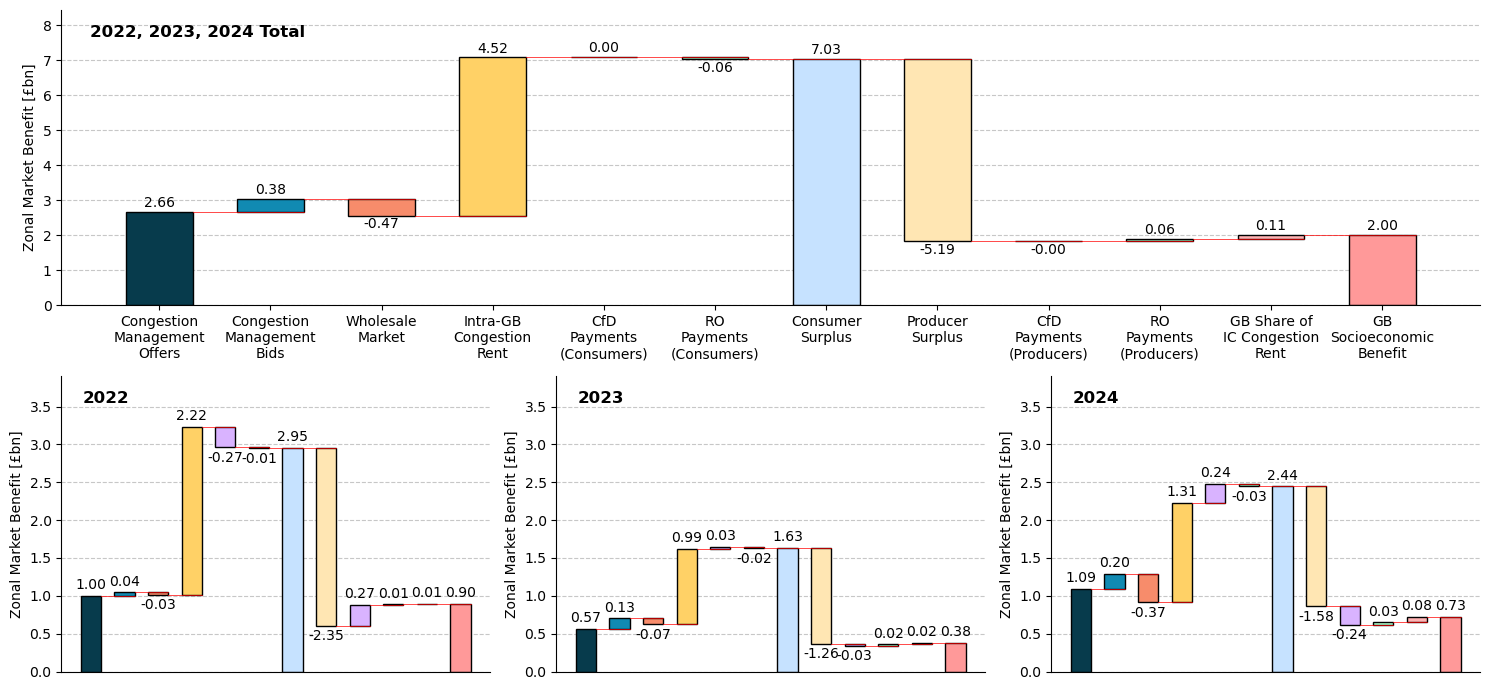

In [23]:
import matplotlib.pyplot as plt


# Create a figure with 3 rows - top row has 1 plot, middle row has 3 plots, bottom row has 3 correlation plots
fig, axs = plt.subplots(2, 3, figsize=(15, 7), 
                        gridspec_kw={'height_ratios': [1, 1], 
                                    'width_ratios': [1, 1, 1]})

# Make the top plot span all three columns
gs = axs[0, 0].get_gridspec()
for ax in axs[0, :]:
    ax.remove()
axs[0, 0] = fig.add_subplot(gs[0, :])

# Define the years to process
years = ['total', '2022', '2023', '2024']

# Process each year and plot on the appropriate axis
for i, year in enumerate(years):
    assert years == ['total', '2022', '2023', '2024'], 'Code expects years to be total, 2022, 2023, 2024'

    if i == 0:
        ax = axs[0, 0]  # Top row for 'total'
    else:
        ax = axs[1, i-1]  # Middle row for individual years

    # Process data for the current year

    if year != 'total':
        time_slice = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31 23:30:00', freq='30min')
        zonal_generator_surplus = zonal_tracker[i]
        national_generator_surplus = national_tracker[i]

        congestion_rent_zonal = ic_rent_tracker_zonal[i]
        congestion_rent_national = ic_rent_tracker_national[i]

    else:
        time_slice = pd.date_range(start='2022-01-01', end='2024-12-31 23:30:00', freq='30min')
        zonal_generator_surplus = zonal_tracker[1] + zonal_tracker[2] + zonal_tracker[3]
        national_generator_surplus = national_tracker[1] + national_tracker[2] + national_tracker[3]

        congestion_rent_zonal = ic_rent_tracker_zonal[0]
        congestion_rent_national = ic_rent_tracker_national[0]
    
    time_slice = (
        time_slice
        .intersection(consumer_cost.index.get_level_values(0))
    )

    assert len(time_slice) > 0, f'No data for {year}'

    idx = pd.IndexSlice

    cc_zonal = consumer_cost.loc[idx[time_slice, :], 'zonal'] * 1e-3
    cc_zonal = cc_zonal.groupby(level=1).sum()

    cc_national = consumer_cost.loc[idx[time_slice, :], 'national'] * 1e-3
    cc_national = cc_national.groupby(level=1).sum()

    # zonal_generator_surplus = get_surplus('zonal', time_slice)
    # national_generator_surplus = get_surplus('national', time_slice)

    cc_diff = cc_national - cc_zonal

    wf = pd.Series(
        index=[
            'offer_cost',
            'bid_cost',
            'wholesale',
            'congestion_rent',
            'cfd_payments_consumer',
            'roc_payments_consumer',
            'net_consumer_benefit',
            'producer_surplus',
            'cfd_payments_producer',
            'roc_payments_producer',
            'ic_congestion_rent',
            'socioeconmic_benefit'
            ],
    )

    wf.loc[wf.index.intersection(cc_diff.index)] = cc_diff.loc[wf.index.intersection(cc_diff.index)]

    wf.loc['cfd_payments_consumer'] = cc_diff.loc['cfd_payments']
    wf.loc['cfd_payments_producer'] = - cc_diff.loc['cfd_payments']
    # wf.loc['cfd_payments_consumer'] = 0
    # wf.loc['cfd_payments_producer'] = 0

    wf.loc['roc_payments_consumer'] = cc_diff.loc['roc_payments']
    wf.loc['roc_payments_producer'] = - cc_diff.loc['roc_payments']
    # wf.loc['roc_payments_consumer'] = 0
    # wf.loc['roc_payments_producer'] = 0

    wf.loc['net_consumer_benefit'] = cc_diff.sum()
    wf.loc['producer_surplus'] = zonal_generator_surplus.sum() - national_generator_surplus.sum()

    wf.loc['ic_congestion_rent'] = congestion_rent_zonal - congestion_rent_national

    wf.loc['socioeconmic_benefit'] = (
        wf.loc['net_consumer_benefit'] + 
        wf.loc['producer_surplus'] - 
        wf.loc['cfd_payments_consumer'] - 
        wf.loc['roc_payments_consumer'] +
        wf.loc['ic_congestion_rent']
    )
    
    # Define the components for the waterfall chart
    components = wf.index.tolist()
    values = wf.values

    # Use the color dictionary or default to a standard color if not in dict
    # Define fallback colors for components not in color_dict
    fallback_colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#d9b3ff', '#b3ffcc', '#c6e2ff', '#ffe6b3', '#d9b3ff', '#b3ffcc', '#ffb3b3']
    colors_wf = []
    for j, component in enumerate(components):
        if component in color_dict:
            colors_wf.append(color_dict[component])
        else:
            # Use a fallback color from our list, cycling if needed
            fallback_idx = j % len(fallback_colors)
            colors_wf.append(fallback_colors[fallback_idx])

    # Starting positions for each bar
    bottoms = np.zeros_like(values)

    # First 6 entries begin at the height of the previous one
    for j in range(1, 6):
        bottoms[j] = bottoms[j-1] + values[j-1]

    # net_consumer_benefit starts at 0
    bottoms[6] = 0

    # The next 3 entries continue from previous bar's height
    for j in range(7, 11):
        bottoms[j] = bottoms[j-1] + values[j-1]

    # socioeconomic_benefit starts from the bottom
    bottoms[11] = 0

    # Create the bars
    running_total = 0
    width = 0.6
    for j, (component, value, bottom, color) in enumerate(zip(components, values, bottoms, colors_wf)):
        ax.bar(j, value, bottom=bottom, color=color, edgecolor='black', label=component, width=width)
        
        # Add value labels on the bars
        if value >= 0:
            va = 'bottom'
            y_pos = bottom + value + 0.05
        else:
            va = 'top'
            y_pos = bottom + value - 0.05
        
        ax.text(j, y_pos, f'{value:.2f}', ha='center', va=va)
        
        if j > 0 and j < 6:  # First section (up to net_consumer_benefit)
            ax.plot([j-1 + width/2, j + width/2], [running_total, running_total], 'r', linewidth=.5)
            running_total += value
        elif j == 6:  # Reset for net_consumer_benefit
            running_total = value
            ax.plot([j-1 + width/2, j + width/2], [running_total, running_total], 'r', linewidth=.5)
        elif j > 6 and j < 12:  # Second section (up to socioeconmic_benefit)
            ax.plot([j-1 + width/2, j + width/2], [running_total, running_total], 'r', linewidth=.5)
            running_total += value
        elif j == 0:
            running_total = value

    friendly_labels = {
        'offer_cost': 'Congestion\nManagement\nOffers',
        'bid_cost': 'Congestion\nManagement\nBids',
        'wholesale': 'Wholesale\nMarket',
        'congestion_rent': 'Intra-GB\nCongestion\nRent',
        'cfd_payments_consumer': 'CfD\nPayments\n(Consumers)',
        'roc_payments_consumer': 'RO\nPayments\n(Consumers)',
        'net_consumer_benefit': 'Consumer\nSurplus',
        'producer_surplus': 'Producer\nSurplus',
        'cfd_payments_producer': 'CfD\nPayments\n(Producers)',
        'roc_payments_producer': 'RO\nPayments\n(Producers)',
        'ic_congestion_rent': 'GB Share of\nIC Congestion\nRent',
        'socioeconmic_benefit': 'GB\nSocioeconomic\nBenefit'
    }

    if i == 1:
        ax.set_ylabel('Zonal Market Benefit [£bn]')
    else:
        ax.set_ylabel('Zonal Market Benefit [£bn]')
    
    # Set xticks only for the top row, remove for bottom row
    if i == 0:  # Top row
        ax.set_xticks(range(len(components)))
        ax.set_xticklabels([friendly_labels[comp] for comp in components])
    else:  # Middle row
        ax.set_xticks([])
        ax.set_xticklabels([])
    
    # Add title for each subplot
    if year == 'total':
        # Add the year as text in the upper left corner instead of using a legend
        ax.text(0.02, 0.95, f'2022, 2023, 2024 Total', transform=ax.transAxes, 
                fontsize=12, fontweight='bold', va='top', ha='left')
    else:
        # Add the year as text in the upper left corner instead of using a legend
        ax.text(0.05, 0.95, f'{year}', transform=ax.transAxes, 
                fontsize=12, fontweight='bold', va='top', ha='left')

    # Add a grid for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)

    # Adjust y-axis limits
    if i == 0:
        ax.set_ylim(0, wf.max() * 1.2)
    else:
        ax.set_ylim(0, 3.9)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()

plt.savefig(f'figures/waterfall_chart_{balancing_markup}.pdf')
plt.show()

#### BOTTOM UP

In [54]:
import yaml
import pypsa
import pandas as pd
import numpy as np
from pathlib import Path

from warnings import filterwarnings
filterwarnings('ignore')

from data_getter import (
    get_all_bmus,
    get_export_revenues,
    get_import_cost,
    get_marginal_costs_data,
    get_thermal_dispatch_data,
    get_dispatch_data,
    get_balancing_expenses,
    get_wholesale_expenses,
    get_europe_prices,
    get_interconnector_dispatch,
    get_marginal_prices,
    get_ic_congestion_rent,
)

with open(Path.cwd().parent / 'data' / 'interconnection_helpers.yaml', 'r') as f:
    interconnection_capacities = yaml.safe_load(f)

dispatch_file = Path.cwd().parent / 'summaries' / 'total_unit_dispatch_flex.csv'
dispatch = get_dispatch_data(dispatch_file)

marginal_cost_file = Path.cwd().parent / 'summaries' / 'total_marginal_costs_flex.csv'
marginal_cost = get_marginal_costs_data(marginal_cost_file)

marginal_prices_fn = Path.cwd().parent / 'summaries' / 'marginal_prices_summary_flex.csv'
marginal_prices = get_marginal_prices(marginal_prices_fn)

thermal_dispatch_file = Path.cwd().parent / 'summaries' / 'total_thermal_dispatch_flex.csv'
thermal_dispatch = get_thermal_dispatch_data(thermal_dispatch_file)

all_units = dispatch.index.get_level_values(0).unique()

ic_dispatch_path = Path.cwd().parent / 'summaries' / 'total_intercon_dispatch_flex.csv'
cons = get_interconnector_dispatch(ic_dispatch_path)

base_path = Path.cwd().parent / 'data' / 'base'
europe_prices = get_europe_prices(base_path)

imports = cons.clip(lower=0)
exports = cons.clip(upper=0).abs()

n = pypsa.Network(
    Path.cwd().parent / 'results' / '2024-03-21' / 'network_flex_s_nodal.nc'
)

bmus = get_all_bmus()
time_slice = pd.date_range(start='2022-01-01', end='2024-12-31', freq='30min')

balancing_markup = 30

No prices for 2022-01-04
No prices for 2024-02-19
No prices for 2024-03-06


INFO:pypsa.io:Imported network network_flex_s_nodal.nc has buses, carriers, generators, links, loads, storage_units


In [55]:
def get_units(carrier):
    if isinstance(carrier, list):
        return bmus.loc[bmus.carrier.isin(carrier)].index
    elif isinstance(carrier, str) and carrier != 'interconnector':
        units = bmus.loc[bmus.carrier.str.contains(carrier)].index
    else:
        units = pd.Index(list(interconnection_capacities['interconnection_mapper'].keys()))
    return units

In [56]:
thermal_units = get_units(['coal', 'biomass', 'fossil'])

In [57]:
time_slice = pd.date_range('2022', '2022-01-20', freq='30min')

In [58]:
idx = pd.IndexSlice

exports.loc[time_slice, idx[:, 'national']].sum().sum()

365871.64077032346

In [59]:
exports.loc[time_slice, idx[:, 'zonal']].sum().sum()

280879.40783227875

In [60]:
thermal_units = get_units(['fossil', 'biomass', 'coal'])
wind_units = get_units(['onwind', 'offwind'])

In [61]:
from tqdm import tqdm


def calculate_bottom_up_SEB(month_year):

    system_tracker = pd.Series(0, index=[
        'fossil_generation_change',
        'import_volume_change',
        'wind_generation_change',
        'export_volume_change',
    ])

    bottom_up_seb = pd.Series(0, index=[
        'import_costs_diff', 'export_revenues_diff', 'congestion_rent_diff',
        'prevented_wholesale_expenses', 'prevented_balancing_expenses'
    ])

    # Convert indices to datetime if needed
    month_start = pd.to_datetime(month_year)
    time_slice = pd.date_range(
        start=month_start,
        end=month_start + pd.offsets.MonthEnd(1) + pd.Timedelta(hours=23, minutes=30),
        freq='30min')

    #### INTERCONNECTOR METRICS ########

    ic_time_slice = time_slice.intersection(exports.index).intersection(imports.index)

    system_tracker.loc['import_volume_change'] = (
        imports.loc[ic_time_slice, idx[:, 'zonal']].sum().sum() - 
        imports.loc[ic_time_slice, idx[:, 'national']].sum().sum()
    ) * 1e-3

    bottom_up_seb.loc['import_costs_diff'] = (
        get_import_cost(imports, europe_prices, ic_time_slice, 'national', n) - 
        get_import_cost(imports, europe_prices, ic_time_slice, 'zonal', n)
    ) * 1e-9

    bottom_up_seb.loc['export_revenues_diff'] = (
        get_export_revenues(exports, marginal_prices, ic_time_slice, 'zonal', n) - 
        get_export_revenues(exports, marginal_prices, ic_time_slice, 'national', n)
    ) * 1e-9

    bottom_up_seb.loc['congestion_rent_diff'] = (
        get_ic_congestion_rent(cons, marginal_prices, europe_prices, n, 'zonal', ic_time_slice) - 
        get_ic_congestion_rent(cons, marginal_prices, europe_prices, n, 'national', ic_time_slice)
    ) * 1e-9

    #### THERMAL GENERATION METRICS ########

    wholesale_expenses_national = 0
    balancing_expenses_national = 0
    wholesale_expenses_zonal = 0
    balancing_expenses_zonal = 0

    for unit in tqdm(thermal_units):

        wholesale_expenses_national += get_wholesale_expenses(
            thermal_dispatch, marginal_cost, unit, 'national', time_slice
        ) or 0.

        wholesale_expenses_zonal += get_wholesale_expenses(
            thermal_dispatch, marginal_cost, unit, 'zonal', time_slice
        ) or 0.

        national_expenses = get_balancing_expenses(
            dispatch, thermal_dispatch, marginal_cost, balancing_markup,
            unit, 'national', time_slice
        )
        balancing_expenses_national += 0 if pd.isna(national_expenses) else national_expenses

        zonal_expenses = get_balancing_expenses(
            dispatch, thermal_dispatch, marginal_cost, balancing_markup,
            unit, 'zonal', time_slice
        )
        balancing_expenses_zonal += 0 if pd.isna(zonal_expenses) else zonal_expenses

    bottom_up_seb.loc['prevented_wholesale_expenses'] = (
        wholesale_expenses_national - wholesale_expenses_zonal
    ) * 1e-9

    bottom_up_seb.loc['prevented_balancing_expenses'] = (
        balancing_expenses_national - balancing_expenses_zonal
    ) * 1e-9

    national_thermal_dispatch = 0.
    zonal_thermal_dispatch = 0.

    for unit in tqdm(thermal_units):

        national_thermal_dispatch += get_unit_schedule(dispatch, unit, 'national', 'wholesale', time_slice)
        national_thermal_dispatch += get_unit_schedule(dispatch, unit, 'national', 'redispatch', time_slice)

        zonal_thermal_dispatch += get_unit_schedule(dispatch, unit, 'zonal', 'wholesale', time_slice)
        zonal_thermal_dispatch += get_unit_schedule(dispatch, unit, 'zonal', 'redispatch', time_slice)
    
    system_tracker.loc['fossil_generation_change'] = (zonal_thermal_dispatch - national_thermal_dispatch) * 1e-3


    #### WIND GENERATION METRICS ########

    national_wind_dispatch = 0.
    zonal_wind_dispatch = 0.

    for unit in tqdm(wind_units):

        national_wind_dispatch += get_unit_schedule(dispatch, unit, 'national', 'wholesale', time_slice)
        national_wind_dispatch += get_unit_schedule(dispatch, unit, 'national', 'redispatch', time_slice)

        zonal_wind_dispatch += get_unit_schedule(dispatch, unit, 'zonal', 'wholesale', time_slice)
        zonal_wind_dispatch += get_unit_schedule(dispatch, unit, 'zonal', 'redispatch', time_slice)

    system_tracker.loc['wind_generation_change'] = (zonal_wind_dispatch - national_wind_dispatch) * 1e-3
    system_tracker.loc['export_volume_change'] = - system_tracker.sum()


    return bottom_up_seb, system_tracker   


seb, st = calculate_bottom_up_SEB('2024-03')

100%|██████████| 184/184 [00:01<00:00, 143.50it/s]


In [62]:
seb_df = []
system_df = []

months = pd.date_range('2022-01', '2024-12', freq='MS')

for month in months:
    seb, st = calculate_bottom_up_SEB(month.strftime('%Y-%m'))
    system_df.append(st.rename(month))
    seb_df.append(seb.rename(month))

100%|██████████| 184/184 [00:01<00:00, 163.31it/s]


In [63]:
seb = pd.concat(seb_df, axis=1).T
system = pd.concat(system_df, axis=1).T

In [64]:
def classify_north_south(lon, lat):
    """Splits GB into north and south, where north represents regions 
    with diminished wholesale market prices"""

    lon = float(lon)
    lat = float(lat)

    m = 0.55
    b = 56.4

    if lat > m * lon + b:
        return 'north'
    else:
        return 'south'


def make_north_south_split(
        bmus,
        carrier,
        ):

    if not isinstance(carrier, str):
        mask = bmus['carrier'].isin(carrier)
    else:
        mask = bmus['carrier'].str.contains(carrier)
    
    coords = bmus[['lat', 'lon']]
    bmus['region'] = coords.apply(
        lambda row: classify_north_south(row['lon'], row['lat']), axis=1
        )

    north = bmus.loc[mask & (bmus['region'] == 'north')].index
    south = bmus.loc[mask & (bmus['region'] == 'south')].index

    return north, south

bmus = pd.read_csv(Path.cwd().parent / 'data' / 'prerun' / 'prepared_bmus.csv', index_col=[0])
bmus = bmus.loc[bmus['lon'] != 'distributed']

north_batteries, south_batteries = make_north_south_split(bmus, 'battery')
north_phs, south_phs = make_north_south_split(bmus, 'phs')

north = north_batteries.union(north_phs)
south = south_batteries.union(south_phs)

Yearly SEB Totals (£bn):
2022    0.639512
2023    0.376329
2024    0.766211
dtype: float64


INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_zonal_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_zonal_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_zonal_solved.nc has buses, carriers, generators, links, loads, storage_units


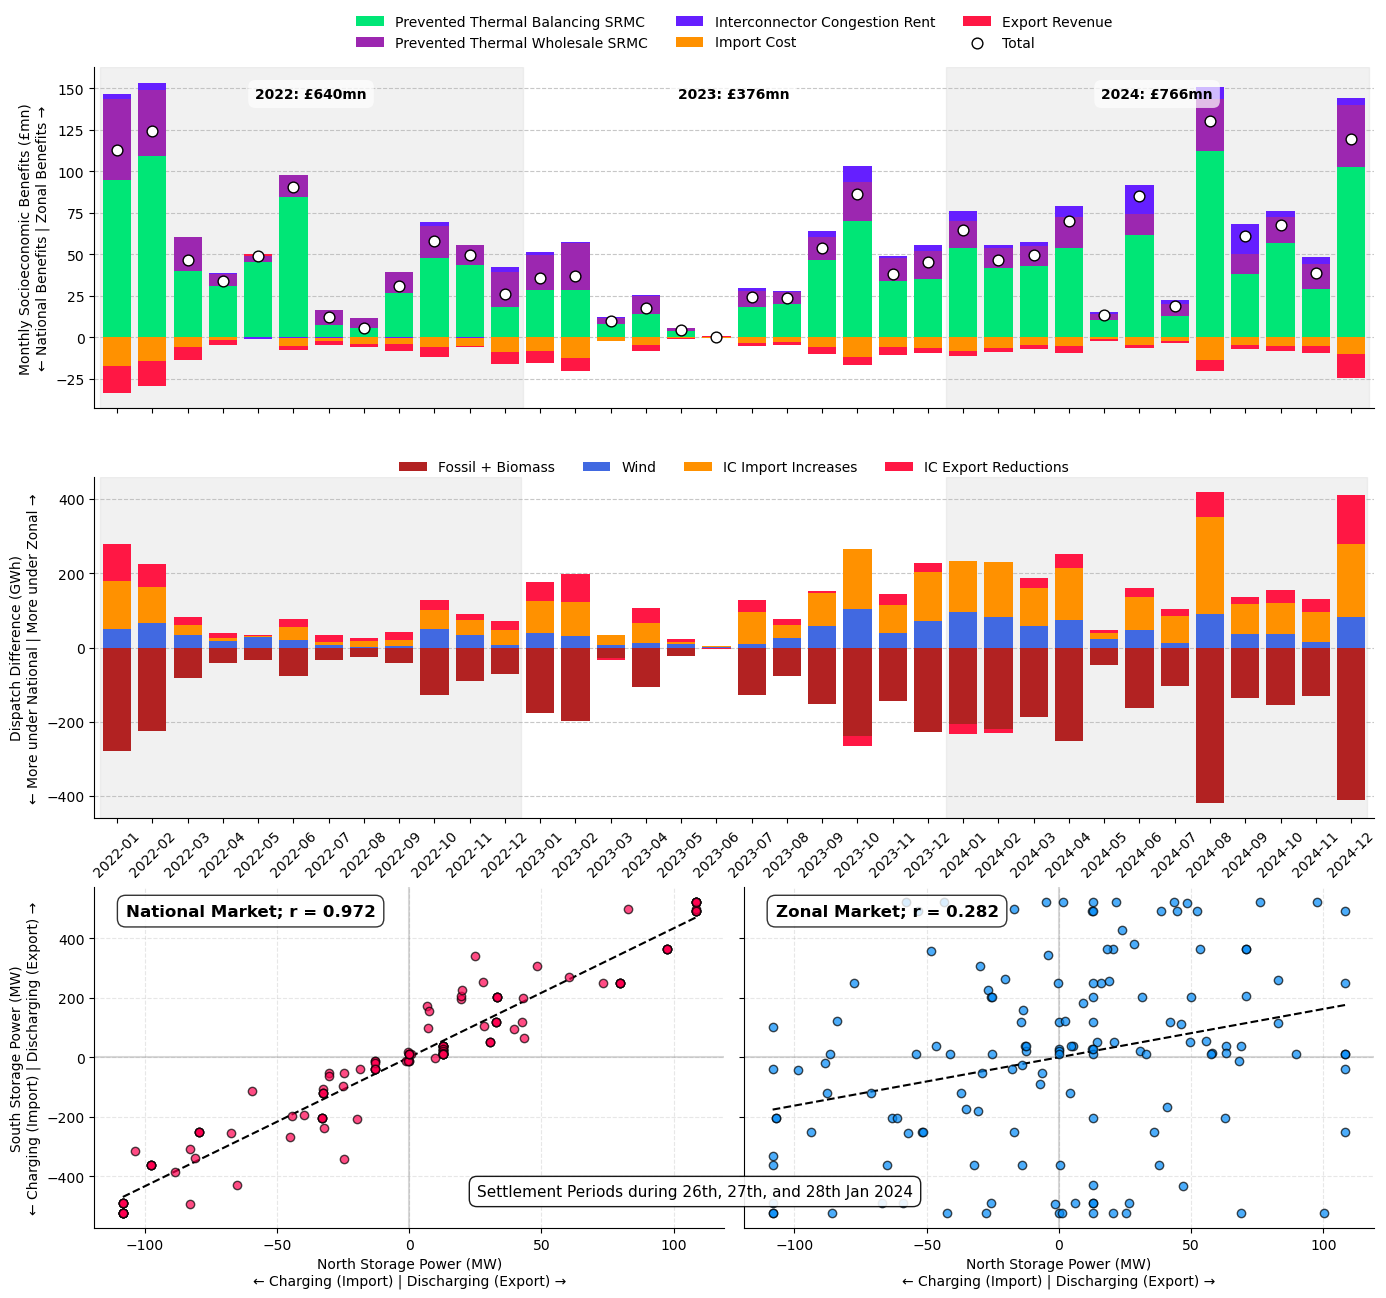

In [65]:
component_labels = {
    'prevented_thermal_operation_cost': 'Thermal Plants Short-Run Marginal Costs\n(excl. Fuel and Carbon Savings and Balancing Premium)',
    'prevented_wholesale_expenses': 'Prevented Thermal Wholesale SRMC',
    'prevented_balancing_expenses': 'Prevented Thermal Balancing SRMC',
    'import_costs_diff': 'Import Cost',
    'export_revenues_diff': 'Export Revenue',
    'congestion_rent_diff': 'Interconnector Congestion Rent',
    'fuel_savings': 'Fuel Savings',
    'balancing_markup': 'Thermal Plants Balancing Premium',
    'carbon_savings': 'Carbon Savings',
}

positive_colors = {
    'prevented_wholesale_expenses': '#9c27b0',  # purple
    'fuel_savings': '#00e676',          # bright green
    'prevented_balancing_expenses': '#00e676', # '#2979ff',      # vibrant blue
    'carbon_savings': '#00e5ff',        # electric cyan
    'congestion_rent_diff': '#651fff',  # deep purple
    'import_costs_diff': '#ff9100',     # vivid orange
    'export_revenues_diff': '#ff1744',   # bright red
}

# Create figure with 3 subplots stacked vertically
fig, axs = plt.subplots(3, 1, figsize=(14, 13), gridspec_kw={'height_ratios': [1, 1, 1]})

ax = axs[0]

seb = seb[[
    'prevented_balancing_expenses',
    'prevented_wholesale_expenses',
    'congestion_rent_diff',
    'import_costs_diff',
    'export_revenues_diff',
]]

pos_data = seb.copy()
neg_data = seb.copy()

pos_data[pos_data < 0] = 0
neg_data[neg_data > 0] = 0

pos_bars = pos_data.mul(1e3).plot(
    kind='bar',
    stacked=True,
    ax=ax,
    width=0.8,
    color=[positive_colors.get(col, '#333333') for col in pos_data.columns]
    )
neg_bars = neg_data.mul(1e3).plot(
    kind='bar',
    stacked=True,
    ax=ax,
    width=0.8,
    color=[positive_colors.get(col, '#333333') for col in neg_data.columns],
    legend=False
    )

total_by_month = seb.sum(axis=1)# .groupby(seb.index.str[:4]).sum()
ax.scatter(range(len(total_by_month)), total_by_month.values * 1e3, color='white', edgecolor='black', s=60, zorder=10)

for year_idx, year in enumerate([2022, 2023, 2024]):
    if year_idx % 2 == 0:  # 2022 and 2024 get grey background
        start_idx = (year - 2022) * 12
        end_idx = start_idx + 11
        ax.axvspan(start_idx - 0.5, end_idx + 0.5, color='lightgrey', alpha=0.3, zorder=-1)

yearly_totals = seb.sum(axis=1).groupby(seb.index.year).sum()

for i, year in enumerate([2022, 2023, 2024]):
    yearly_total = yearly_totals[year]

    x_pos = i * 12 + 5.5
    y_pos = ax.get_ylim()[1] * 0.9  # Position at 85% of the y-axis height
    ax.text(x_pos, y_pos, f"{year}: £{yearly_total*1000:.0f}mn", 
            ha='center', va='center', fontweight='bold', 
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))

ax.set_ylabel('Monthly Socioeconomic Benefits (£mn)\n← National Benefits | Zonal Benefits →')
ax.set_xlabel('')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# Add white dot with black edge to legend
dot_handle = plt.scatter([], [], color='white', edgecolor='black', s=60)
handles = [by_label[label] for label in seb.columns] + [dot_handle]
labels = [component_labels.get(label, label) for label in seb.columns] + ['Total']

ax.legend(
    handles,
    labels,
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.19),
    ncol=3,
    frameon=False,
)

ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Hide x-tick labels for the first plot
ax.tick_params(labelbottom=False)

# --- Second plot (Dispatch Difference) ---
ax = axs[1]

carriers = ['fossil', 'wind', 'interconnector']
colors = {'fossil': 'firebrick', 'wind': 'royalblue', 'interconnector': '#ff9100'}

carrier_display_names = {
    'fossil': 'Fossil + Biomass',
    'wind': 'Wind',
    'interconnector': 'IC Import Increases',
}
colors_display = {carrier_display_names.get(c, c): color for c, color in colors.items()}

column_mapping = {
    'fossil_generation_change': carrier_display_names['fossil'],
    'import_volume_change': carrier_display_names['interconnector'],
    'wind_generation_change': carrier_display_names['wind']
}

dispatch_df = system.copy()
dispatch_df = dispatch_df.rename(columns=column_mapping)

dispatch_df = dispatch_df[[carrier_display_names[c] for c in carriers]]

dispatch_df['IC Export Reductions'] = -dispatch_df.sum(axis=1)
colors_display['IC Export Reductions'] = '#ff1744'

bars = dispatch_df.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=[colors_display[c] for c in dispatch_df.columns],
    width=0.8
    )

for year_idx, year in enumerate([2022, 2023, 2024]):
    if year_idx % 2 == 0:  # 2022 and 2024 get grey background
        start_idx = (year - 2022) * 12
        end_idx = start_idx + 11
        ax.axvspan(start_idx - 0.5, end_idx + 0.5 - 0.05, color='lightgrey', alpha=0.3, zorder=-1)

ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_ylabel('Dispatch Difference (GWh)\n← More under National | More under Zonal →')
ax.set_xlabel('')

ax.set_xticklabels([d.strftime('%Y-%m') for d in dispatch_df.index], rotation=45)

ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Move legend to center above the plot in three columns without frame
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, 1.085), ncol=5, frameon=False)

# Calculate and print total SEB for each year
print("Yearly SEB Totals (£bn):")
print(yearly_totals)

# --- Third row with storage correlation plots ---
import pypsa
from scipy import stats

# Concatenate data for three days
days = ['2024-01-26', '2024-01-27', '2024-01-28']
nat_data = []
zon_data = []

for day in days:
    nat = pypsa.Network(Path.cwd().parent / 'results' / day / 'network_flex_s_national_solved.nc')
    zon = pypsa.Network(Path.cwd().parent / 'results' / day / 'network_flex_s_zonal_solved.nc')
    
    nat_north = nat.storage_units_t.p[north].sum(axis=1)
    nat_south = nat.storage_units_t.p[south].sum(axis=1)
    zon_north = zon.storage_units_t.p[north].sum(axis=1)
    zon_south = zon.storage_units_t.p[south].sum(axis=1)
    
    nat_data.append(pd.DataFrame({'North': nat_north, 'South': nat_south}))
    zon_data.append(pd.DataFrame({'North': zon_north, 'South': zon_south}))

nat_df = pd.concat(nat_data)
zon_df = pd.concat(zon_data)

# Calculate correlation coefficients
nat_corr = nat_df['North'].corr(nat_df['South'])
zon_corr = zon_df['North'].corr(zon_df['South'])

# Fix the GridSpec issue by creating two separate axes instead of using a GridSpec slice
axs[2].remove()  # Remove the original third axis
ax3 = fig.add_subplot(3, 2, 5)  # National plot (bottom left)
ax4 = fig.add_subplot(3, 2, 6)  # Zonal plot (bottom right)

# National model plot
ax3.scatter(nat_df['North'], nat_df['South'], alpha=0.7, c='#ff0050', edgecolor='k', zorder=10)
ax3.set_xlabel('North Storage Power (MW)\n← Charging (Import) | Discharging (Export) →', fontsize=10)
ax3.set_ylabel('South Storage Power (MW)\n← Charging (Import) | Discharging (Export) →', fontsize=10)
ax3.grid(alpha=0.3, linestyle='--')
ax3.set_axisbelow(True)
ax3.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax3.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
# Create text with frame for national market
text_props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor='black')
ax3.text(0.05, 0.95, f'National Market; r = {nat_corr:.3f}', transform=ax3.transAxes, 
         fontsize=12, fontweight='bold', va='top', bbox=text_props, zorder=11)

# Add regression line with confidence interval
slope, intercept, r_value, p_value, std_err = stats.linregress(nat_df['North'], nat_df['South'])
x_range = np.linspace(nat_df['North'].min(), nat_df['North'].max(), 100)
y_pred = intercept + slope * x_range
ax3.plot(x_range, y_pred, color='black', linewidth=1.5, linestyle='--')

# Add confidence interval
n = len(nat_df)
y_err = std_err * np.sqrt(1/n + (x_range - nat_df['North'].mean())**2 / 
                          np.sum((nat_df['North'] - nat_df['North'].mean())**2))
# ax3.fill_between(x_range, y_pred - 2*y_err, y_pred + 2*y_err, color='#FF00FF', alpha=0.1)

# Zonal model plot
ax4.scatter(zon_df['North'], zon_df['South'], alpha=0.7, c='#008bfa', edgecolor='k', zorder=10)
ax4.set_xlabel('North Storage Power (MW)\n← Charging (Import) | Discharging (Export) →', fontsize=10)
ax4.set_yticklabels([])
ax4.grid(alpha=0.3, linestyle='--')
ax4.set_axisbelow(True)
ax4.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax4.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
ax4.text(0.05, 0.95, f'Zonal Market; r = {zon_corr:.3f}', transform=ax4.transAxes, 
         fontsize=12, fontweight='bold', va='top', bbox=text_props, zorder=11)

# Add regression line with confidence interval
slope, intercept, r_value, p_value, std_err = stats.linregress(zon_df['North'], zon_df['South'])
x_range = np.linspace(zon_df['North'].min(), zon_df['North'].max(), 100)
y_pred = intercept + slope * x_range
ax4.plot(x_range, y_pred, color='black', linewidth=1.5, linestyle='--')

# Add confidence interval
n = len(zon_df)
y_err = std_err * np.sqrt(1/n + (x_range - zon_df['North'].mean())**2 / 
                          np.sum((zon_df['North'] - zon_df['North'].mean())**2))
# ax4.fill_between(x_range, y_pred - 2*y_err, y_pred + 2*y_err, color='#FF00FF', alpha=0.1)

# Add framed text at the bottom center across both subplots
date_text_props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='black')
fig.text(0.5, 0.08, 'Settlement Periods during 26th, 27th, and 28th Jan 2024', 
         ha='center', va='bottom', fontsize=11, 
         bbox=date_text_props, zorder=12)

for a in [ax3, ax4]:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(hspace=0.2)  # Adjust space between subplots

plt.savefig(f'figures/socioeconomic_benefits_{balancing_markup}.pdf', bbox_inches='tight')
plt.show()

In [66]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

idx = pd.IndexSlice

In [67]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

all_bids = []
days = pd.date_range(start='2022-01-01', end='2024-12-31').strftime('%Y-%m-%d')

for day in tqdm(days):

    try:
        bids = pd.read_csv(Path.cwd().parent / 'data' / 'base' / f'{day}' / 'bids.csv', index_col=[0,1], parse_dates=True)
    except FileNotFoundError:
        continue

    all_bids.append(bids)

all_bids = pd.concat(all_bids)

100%|██████████| 1096/1096 [00:07<00:00, 150.75it/s]


In [68]:
ss = all_bids.loc[idx[:, 'vol'], :].sum(axis=1)
ss.index = ss.index.get_level_values(0)
monthly = ss.groupby(ss.index.strftime('%Y-%m')).sum()

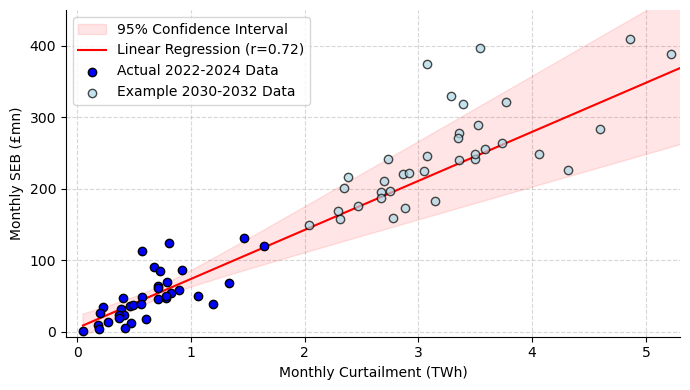

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Extract data for the plot - swap x and y
y = seb.sum(axis=1) * 1000  # Now y is monthly_totals in £mn
x = monthly.values * 1e-6  # Now x is curtailment in GWh

# Calculate linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Create figure
fig, ax = plt.subplots(figsize=(7, 4))

# Calculate 95% confidence interval
n = len(x)
mean_x = np.mean(x)
# Sum of squares of x deviations
ss_x = np.sum((x - mean_x)**2)
# Standard error of the regression
se = np.sqrt(np.sum((y - (intercept + slope * x))**2) / (n - 2))
# Standard error of the slope
se_slope = se / np.sqrt(ss_x)
# t-value for 95% confidence interval
t_value = stats.t.ppf(0.975, n - 2)
# Confidence interval for the slope
ci = t_value * se_slope

# Get the full x range for the plot
x_min, x_max = min(x), max(x)
x_full_range = np.linspace(x_min, x_max * 5, 100)  # Extend range for projection

# Create projected data by shifting original points to the right
# Shift x values by 5 times the mean of original x values
x_projected = x + (5 * mean_x)
# Increase spread by scaling the deviations from the mean by 2
x_projected = mean_x * 5 + (x - mean_x) * 2

# For y-axis, apply similar transformation but scaled by the slope
mean_y = np.mean(y)
std_y = np.std(y)
# Scale the shift and spread factors by the slope to maintain the relationship
y_projected = y + (5 * mean_x * slope)  # Shift by equivalent amount on y-axis
# Increase spread proportionally to maintain relationship with x
y_projected = mean_y + (5 * mean_x * slope) + (y - mean_y) * 2 - 23

# Calculate confidence bands across the full range
y_upper = intercept + slope * x_full_range + t_value * se * np.sqrt(1/n + (x_full_range - mean_x)**2 / ss_x)
y_lower = intercept + slope * x_full_range - t_value * se * np.sqrt(1/n + (x_full_range - mean_x)**2 / ss_x)

# Create x values for regression line
x_line = np.linspace(x_min, max(x_projected) * 1.1, 100)
y_line = slope * x_line + intercept

# Plot confidence bands and regression line first (so they appear below the points)
ax.fill_between(x_full_range, y_lower, y_upper, color='red', alpha=0.1, label='95% Confidence Interval')
ax.plot(x_line, y_line, color='red', label=f'Linear Regression (r={r_value:.2f})')

# Plot the original scatter points with distinct black edges
ax.scatter(x, y, color='blue', edgecolor='black', linewidth=1, label='Actual 2022-2024 Data', zorder=10)

# Plot projected data with distinct black edges
ax.scatter(x_projected, y_projected, color='lightblue', edgecolor='black', linewidth=1, alpha=0.7, 
           label='Example 2030-2032 Data', zorder=10)

# Add labels and legend
ax.set_xlabel('Monthly Curtailment (TWh)')
ax.set_ylabel('Monthly SEB (£mn)')
# ax.set_title('Relationship Between Monthly SEB and Curtailment')
ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(True, linestyle='--', alpha=0.5)
ax.set_axisbelow(True)

plt.tight_layout()

ax.set_xlim(-0.1, 5.3)
ax.set_ylim(-7, 450)

plt.savefig('figures/curtailment_seb_projections.pdf', bbox_inches='tight')
plt.show()